# OptiML Project - Text classification models optimization

## Imports

In [1]:
import random
from collections import namedtuple, Counter
from functools import partial
import gc
from dataclasses import dataclass

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import tqdm, trange
# from tqdm import tqdm, trange
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AutoConfig

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print('Using GPU')
else:
    raise Exception('Using CPU')

Using GPU


## Setup the seed
For reproducibility purposes, we will set the seed of the random number generators

In [3]:
def seed_everything(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    random.seed(seed)


seed = 42
seed_everything(seed)

## Load the data

In [4]:
dataset = load_dataset('cwchang/text-classification-dataset-example')
dataset

Using the latest cached version of the dataset since cwchang/text-classification-dataset-example couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at C:\Users\Romain\.cache\huggingface\datasets\cwchang___text-classification-dataset-example\default\0.0.0\fdbb64893dd6057464c6289a9a88a5b4048385ff (last modified on Mon Apr 22 21:08:04 2024).


DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'id'],
        num_rows: 15000
    })
    validation: Dataset({
        features: ['label', 'text', 'id'],
        num_rows: 3000
    })
    test: Dataset({
        features: ['label', 'text', 'id'],
        num_rows: 7500
    })
})

In [5]:
pd.DataFrame(dataset['train'])

,label,text,id
0,book_flight,i need you to book me a flight from ft lauderd...,train-0
1,schedule_maintenance,my check engine light is on and i need to take...,train-1
2,reminder,is the company party on my list of reminders,train-2
3,are_you_a_bot,are you a human,train-3
4,todo_list_update,i need to do cleaning so add it to my to do list,train-4
...,...,...,...
14995,calculator,what is the square root of 10294,train-14995
14996,reminder_update,remind me again please,train-14996
14997,alarm,create an alarm for 6am,train-14997
14998,translate,how would i say pleased to meet you if i were ...,train-14998


### Dataset exploration

In [6]:
train_dataset = dataset['train']
val_dataset = dataset['validation']
test_dataset = dataset['test']

train_dataset, val_dataset, test_dataset

(Dataset({
     features: ['label', 'text', 'id'],
     num_rows: 15000
 }),
 Dataset({
     features: ['label', 'text', 'id'],
     num_rows: 3000
 }),
 Dataset({
     features: ['label', 'text', 'id'],
     num_rows: 7500
 }))

In [7]:
pd.DataFrame(train_dataset)

,label,text,id
0,book_flight,i need you to book me a flight from ft lauderd...,train-0
1,schedule_maintenance,my check engine light is on and i need to take...,train-1
2,reminder,is the company party on my list of reminders,train-2
3,are_you_a_bot,are you a human,train-3
4,todo_list_update,i need to do cleaning so add it to my to do list,train-4
...,...,...,...
14995,calculator,what is the square root of 10294,train-14995
14996,reminder_update,remind me again please,train-14996
14997,alarm,create an alarm for 6am,train-14997
14998,translate,how would i say pleased to meet you if i were ...,train-14998


In [8]:
pd.DataFrame(val_dataset)

,label,text,id
0,cook_time,how long should i cook steak for,eval-0
1,balance,please tell me how much money i have in my ban...,eval-1
2,gas,what is the gas level in my gas tank,eval-2
3,time,how late is it now in ourense,eval-3
4,car_rental,i really need to get a volkswagen car rental f...,eval-4
...,...,...,...
2995,current_location,please tell me the address of my current location,eval-2995
2996,replacement_card_duration,what is the eta on getting a replacement card,eval-2996
2997,change_volume,please turn your volume up,eval-2997
2998,improve_credit_score,show me a plan to help my credit score rating,eval-2998


In [9]:
pd.DataFrame(test_dataset)

,label,text,id
0,bill_balance,how much are my rent and cable,test-0
1,restaurant_suggestion,i need some suggestions for dinner places tonight,test-1
2,report_lost_card,can you report a lost card for me,test-2
3,timezone,timezone currently in mobile,test-3
4,what_is_your_name,tell me what to call you,test-4
...,...,...,...
7495,current_location,please tell me the address of my current location,eval-2995
7496,replacement_card_duration,what is the eta on getting a replacement card,eval-2996
7497,change_volume,please turn your volume up,eval-2997
7498,improve_credit_score,show me a plan to help my credit score rating,eval-2998


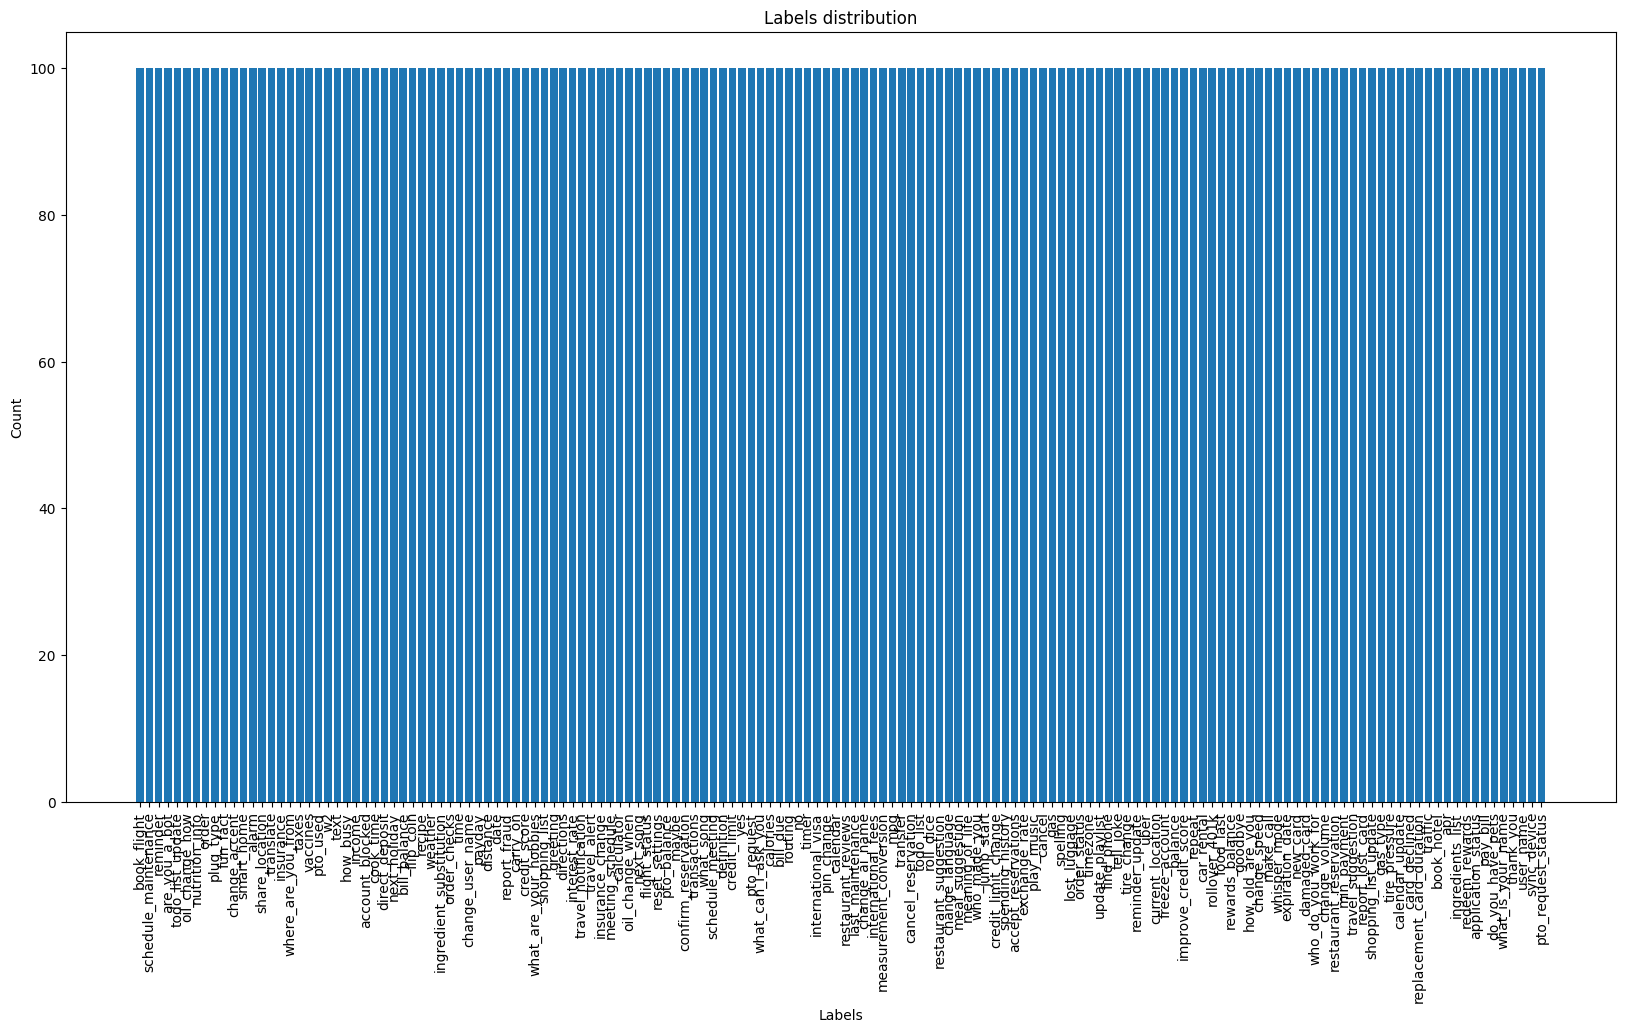

In [10]:
labels_counter = Counter([d['label'] for d in train_dataset])
plt.figure(figsize=(20, 10))
plt.bar(labels_counter.keys(), labels_counter.values())
plt.xticks(rotation=90)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Labels distribution')
plt.show()

In [11]:
classes = list(set(train_dataset['label']))
label2id = {c: i for i, c in enumerate(classes)}
id2label = {i: c for c, i in label2id.items()}
num_labels = len(classes)
pd.DataFrame({'class': list(classes), 'idx': list(label2id.values())})

,class,idx
0,min_payment,0
1,fun_fact,1
2,next_holiday,2
3,tell_joke,3
4,reminder_update,4
...,...,...
145,reminder,145
146,routing,146
147,ingredients_list,147
148,transfer,148


In [12]:
num_labels

150

## Load pretrained tokenizer (RoBERTa)

In [13]:
model_name = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(model_name)
# model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=num_labels).to(device)

## Prepare dataloaders

In [14]:
def prepare_dataset(dataset):
    texts = [d['text'] for d in dataset]
    tokenized = tokenizer(texts, padding=True, truncation=True, return_tensors='pt').to(device)
    labels_ids = [label2id[d['label']] for d in dataset]
    labels = torch.tensor(labels_ids).to(device)
    return TensorDataset(tokenized['input_ids'], tokenized['attention_mask'], labels)

In [15]:
train_tokenized = prepare_dataset(train_dataset)
train_dataloader = DataLoader(train_tokenized, batch_size=128, shuffle=True)

In [16]:
val_tokenized = prepare_dataset(val_dataset)
val_dataloader = DataLoader(val_tokenized, batch_size=128, shuffle=False)

In [17]:
test_tokenized = prepare_dataset(test_dataset)
test_dataloader = DataLoader(test_tokenized, batch_size=128, shuffle=False)

## Training and evaluation functions

In [18]:
def train(model: nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          val_dataloader: torch.utils.data.DataLoader,
          optimizer: optim.Optimizer,
          scheduler: optim.lr_scheduler._LRScheduler,
          num_epochs: int):
    seed_everything(seed)
    if scheduler is None:
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=1)
    t = trange(num_epochs, desc='Training', leave=True)
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    for epoch in t:
        train_loss = 0
        train_acc = 0
        model.zero_grad()
        optimizer.zero_grad()
        model.train()
        for X_batch, attention_mask, y_batch in tqdm(train_dataloader, leave=False, desc='Epoch', position=0):
            model.zero_grad()
            optimizer.zero_grad()
            outputs = model(X_batch, attention_mask=attention_mask, labels=y_batch)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += (torch.argmax(outputs.logits, 1) == y_batch).sum().item() / y_batch.size(0)

        train_loss /= len(train_dataloader)
        train_acc /= len(train_dataloader)
        model.eval()
        acc, val_loss, _ = evaluate(model, val_dataloader)
        scheduler.step()
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(acc)
        t.set_postfix(train_loss=train_loss, val_loss=val_loss, acc=acc)
    return namedtuple('Training', ['train_losses', 'val_losses', 'train_accs', 'val_accs'])(train_losses, val_losses, train_accs, val_accs)


def plot_training(training):
    """
    Plot a single graph with training and validation losses on the left axis and validation accuracy on the right axis.
    :param training: namedtuple('Training', ['train_losses', 'val_losses', 'accs'])
    :return: None
    """
    epochs = range(1, len(training.train_losses) + 1)
    
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot training and validation losses on left axis
    color = 'tab:blue'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color=color)
    ax1.plot(epochs, training.train_losses, color=color, label='Train Loss')
    ax1.plot(epochs, training.val_losses, color='tab:cyan', label='Val Loss')
    ax1.tick_params(axis='y', labelcolor=color)

    # Create second y-axis for validation accuracy on right axis
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Accuracy', color=color)
    ax2.plot(epochs, training.train_accs, color=color, linestyle='--', label='Train Accuracy')
    ax2.plot(epochs, training.val_accs, color='tab:orange', linestyle='--', label='Val Accuracy')
    ax2.tick_params(axis='y', labelcolor=color)

    # Set title and legend
    plt.title('Training and Validation Metrics')
    fig.tight_layout()
    fig.legend(loc='upper right')

    # Show plot
    plt.show()


def evaluate(model: nn.Module,
             test_dataloader: torch.utils.data.DataLoader):
    model.eval()
    confusion_matrix = np.zeros((num_labels, num_labels))
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, attention_mask, y_batch in tqdm(test_dataloader, leave=False, desc='Evaluation', position=0):
            outputs = model(X_batch, attention_mask=attention_mask, labels=y_batch)
            loss = outputs.loss
            test_loss += loss.item()
            _, predicted = torch.max(outputs.logits, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
            for t, p in zip(y_batch.view(-1), predicted.view(-1)):
                confusion_matrix[p.long(), t.long()] += 1
    acc = correct / total
    test_loss /= len(test_dataloader)
    return namedtuple('Evaluation', ['accuracy', 'loss', 'confusion_matrix'])(acc, test_loss, confusion_matrix)


def plot_confusion_matrix(confusion_matrix):
    plt.figure(figsize=(30, 30))
    plt.imshow(confusion_matrix, cmap='Reds', interpolation='nearest')
    plt.xticks(np.arange(num_labels), classes, rotation=90)
    plt.yticks(np.arange(num_labels), classes)
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.show()

## Hyperparameters

In [19]:
@dataclass
class TrainingConfig:
    optimizer: '(params, lr, weight_decay) -> Optimizer'
    num_epochs: int
    learning_rate: float
    weight_decay: float

In [20]:
num_epochs = 10
weight_decay = 1e-2

In [21]:
configs = {
    'SGD': TrainingConfig(optimizer=torch.optim.SGD,
                          num_epochs=num_epochs,
                          learning_rate=5e-2,
                          weight_decay=weight_decay),

    'SGD with momentum': TrainingConfig(optimizer=partial(torch.optim.SGD, momentum=0.9),
                                        num_epochs=num_epochs,
                                        learning_rate=5e-3,
                                        weight_decay=weight_decay),

    'Adam': TrainingConfig(optimizer=torch.optim.Adam,
                           num_epochs=num_epochs,
                           learning_rate=5e-5,
                           weight_decay=weight_decay),

    'AdamW': TrainingConfig(optimizer=torch.optim.AdamW,
                            num_epochs=num_epochs, learning_rate=5e-5,
                            weight_decay=weight_decay),

    'RMSprop': TrainingConfig(optimizer=torch.optim.RMSprop,
                            num_epochs=num_epochs, learning_rate=5e-5,
                            weight_decay=weight_decay),
}

## Fine-tuning the model 
In this section we will try to fine tune the model using different optimizers to compare their performance against each other when fine-tuning transformers.

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Optimizer: SGD Learning rate: 0.05 Weight decay: 0.01 Num epochs: 10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch:   0%|          | 0/118 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:   0%|          | 0/118 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:   0%|          | 0/118 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:   0%|          | 0/118 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:   0%|          | 0/118 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:   0%|          | 0/118 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:   0%|          | 0/118 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:   0%|          | 0/118 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:   0%|          | 0/118 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:   0%|          | 0/118 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/59 [00:00<?, ?it/s]

Validation accuracy: 0.7958666666666666
Validation loss: 0.878837465229681


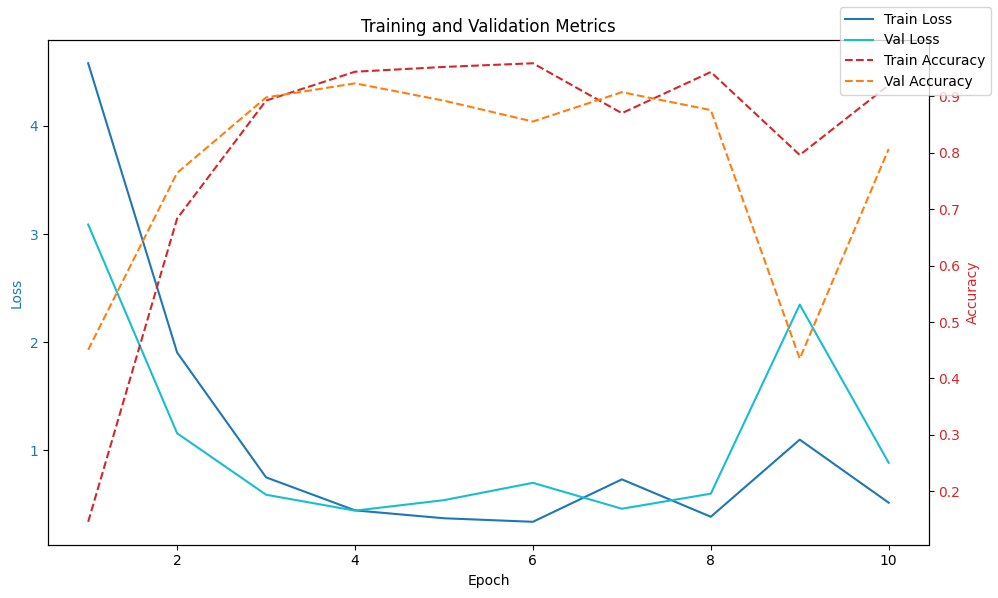

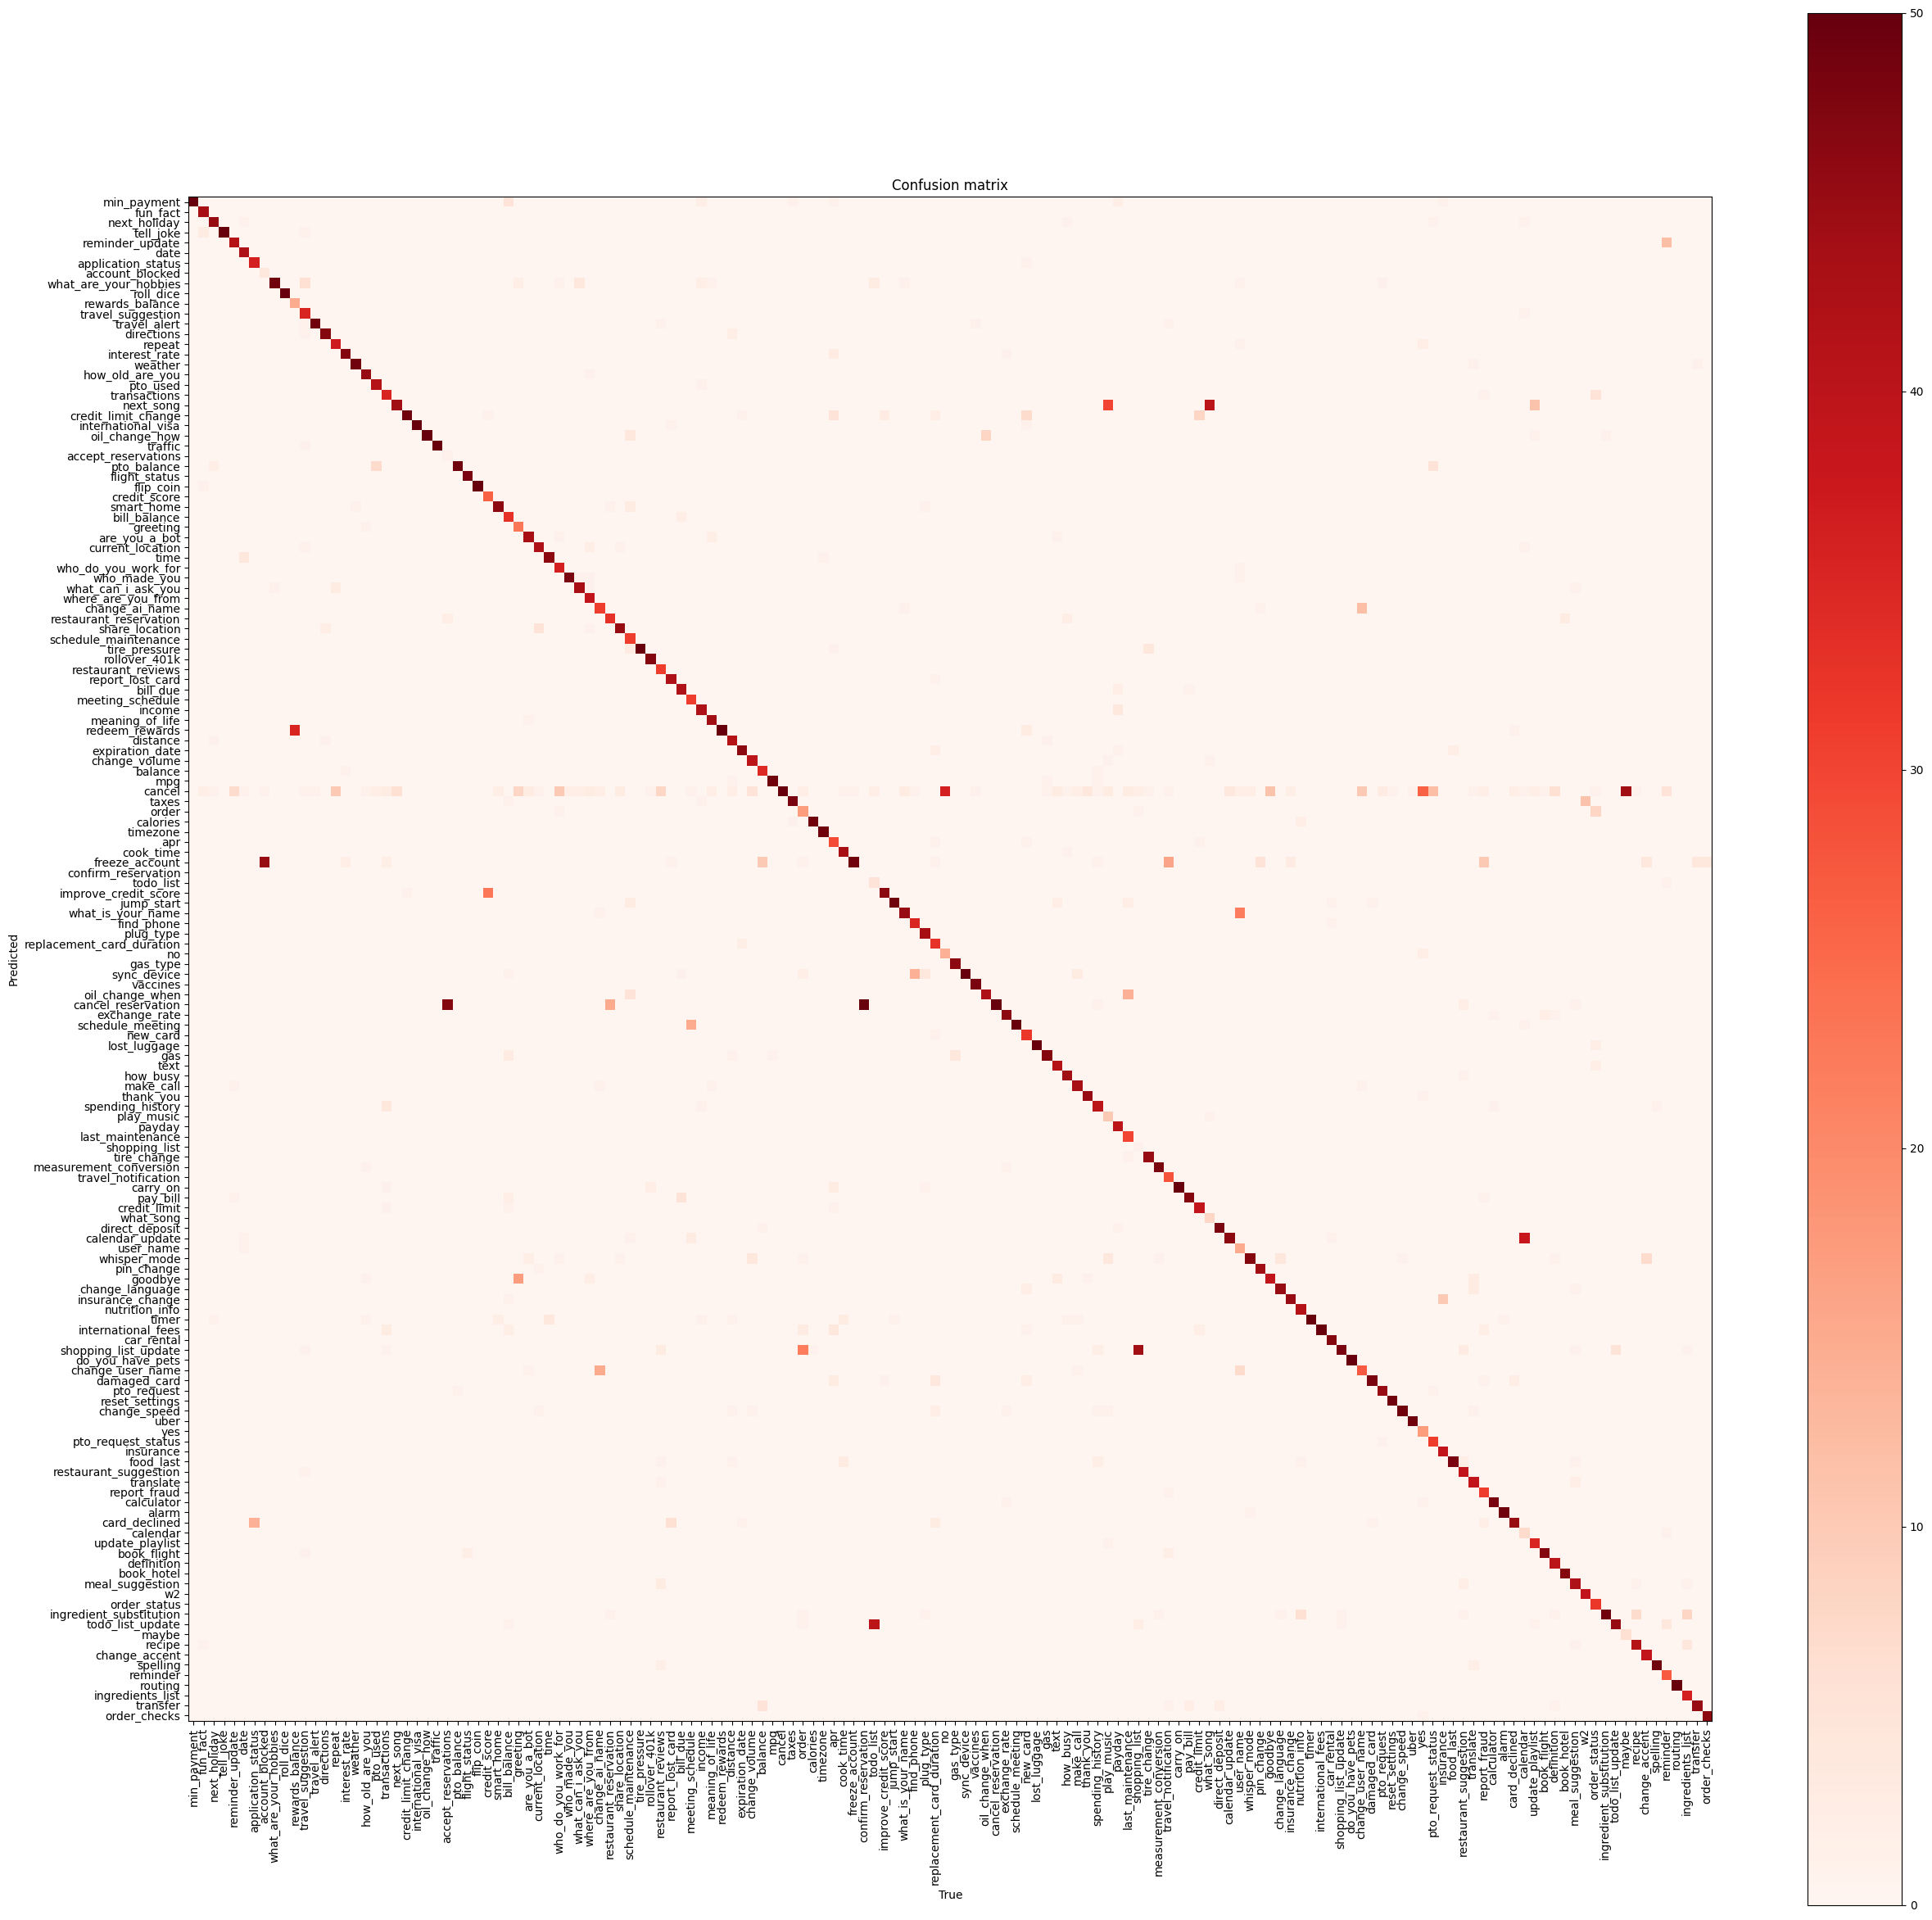

##################################################


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Optimizer: SGD with momentum Learning rate: 0.005 Weight decay: 0.01 Num epochs: 10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch:   0%|          | 0/118 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:   0%|          | 0/118 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:   0%|          | 0/118 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:   0%|          | 0/118 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:   0%|          | 0/118 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:   0%|          | 0/118 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:   0%|          | 0/118 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:   0%|          | 0/118 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:   0%|          | 0/118 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:   0%|          | 0/118 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/59 [00:00<?, ?it/s]

Validation accuracy: 0.9137333333333333
Validation loss: 0.4439447421138569


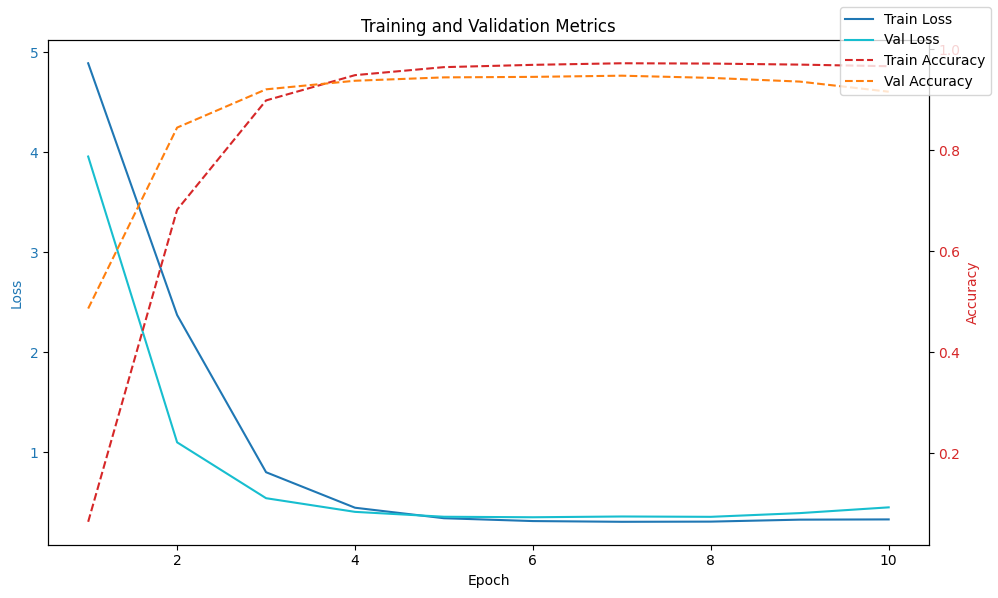

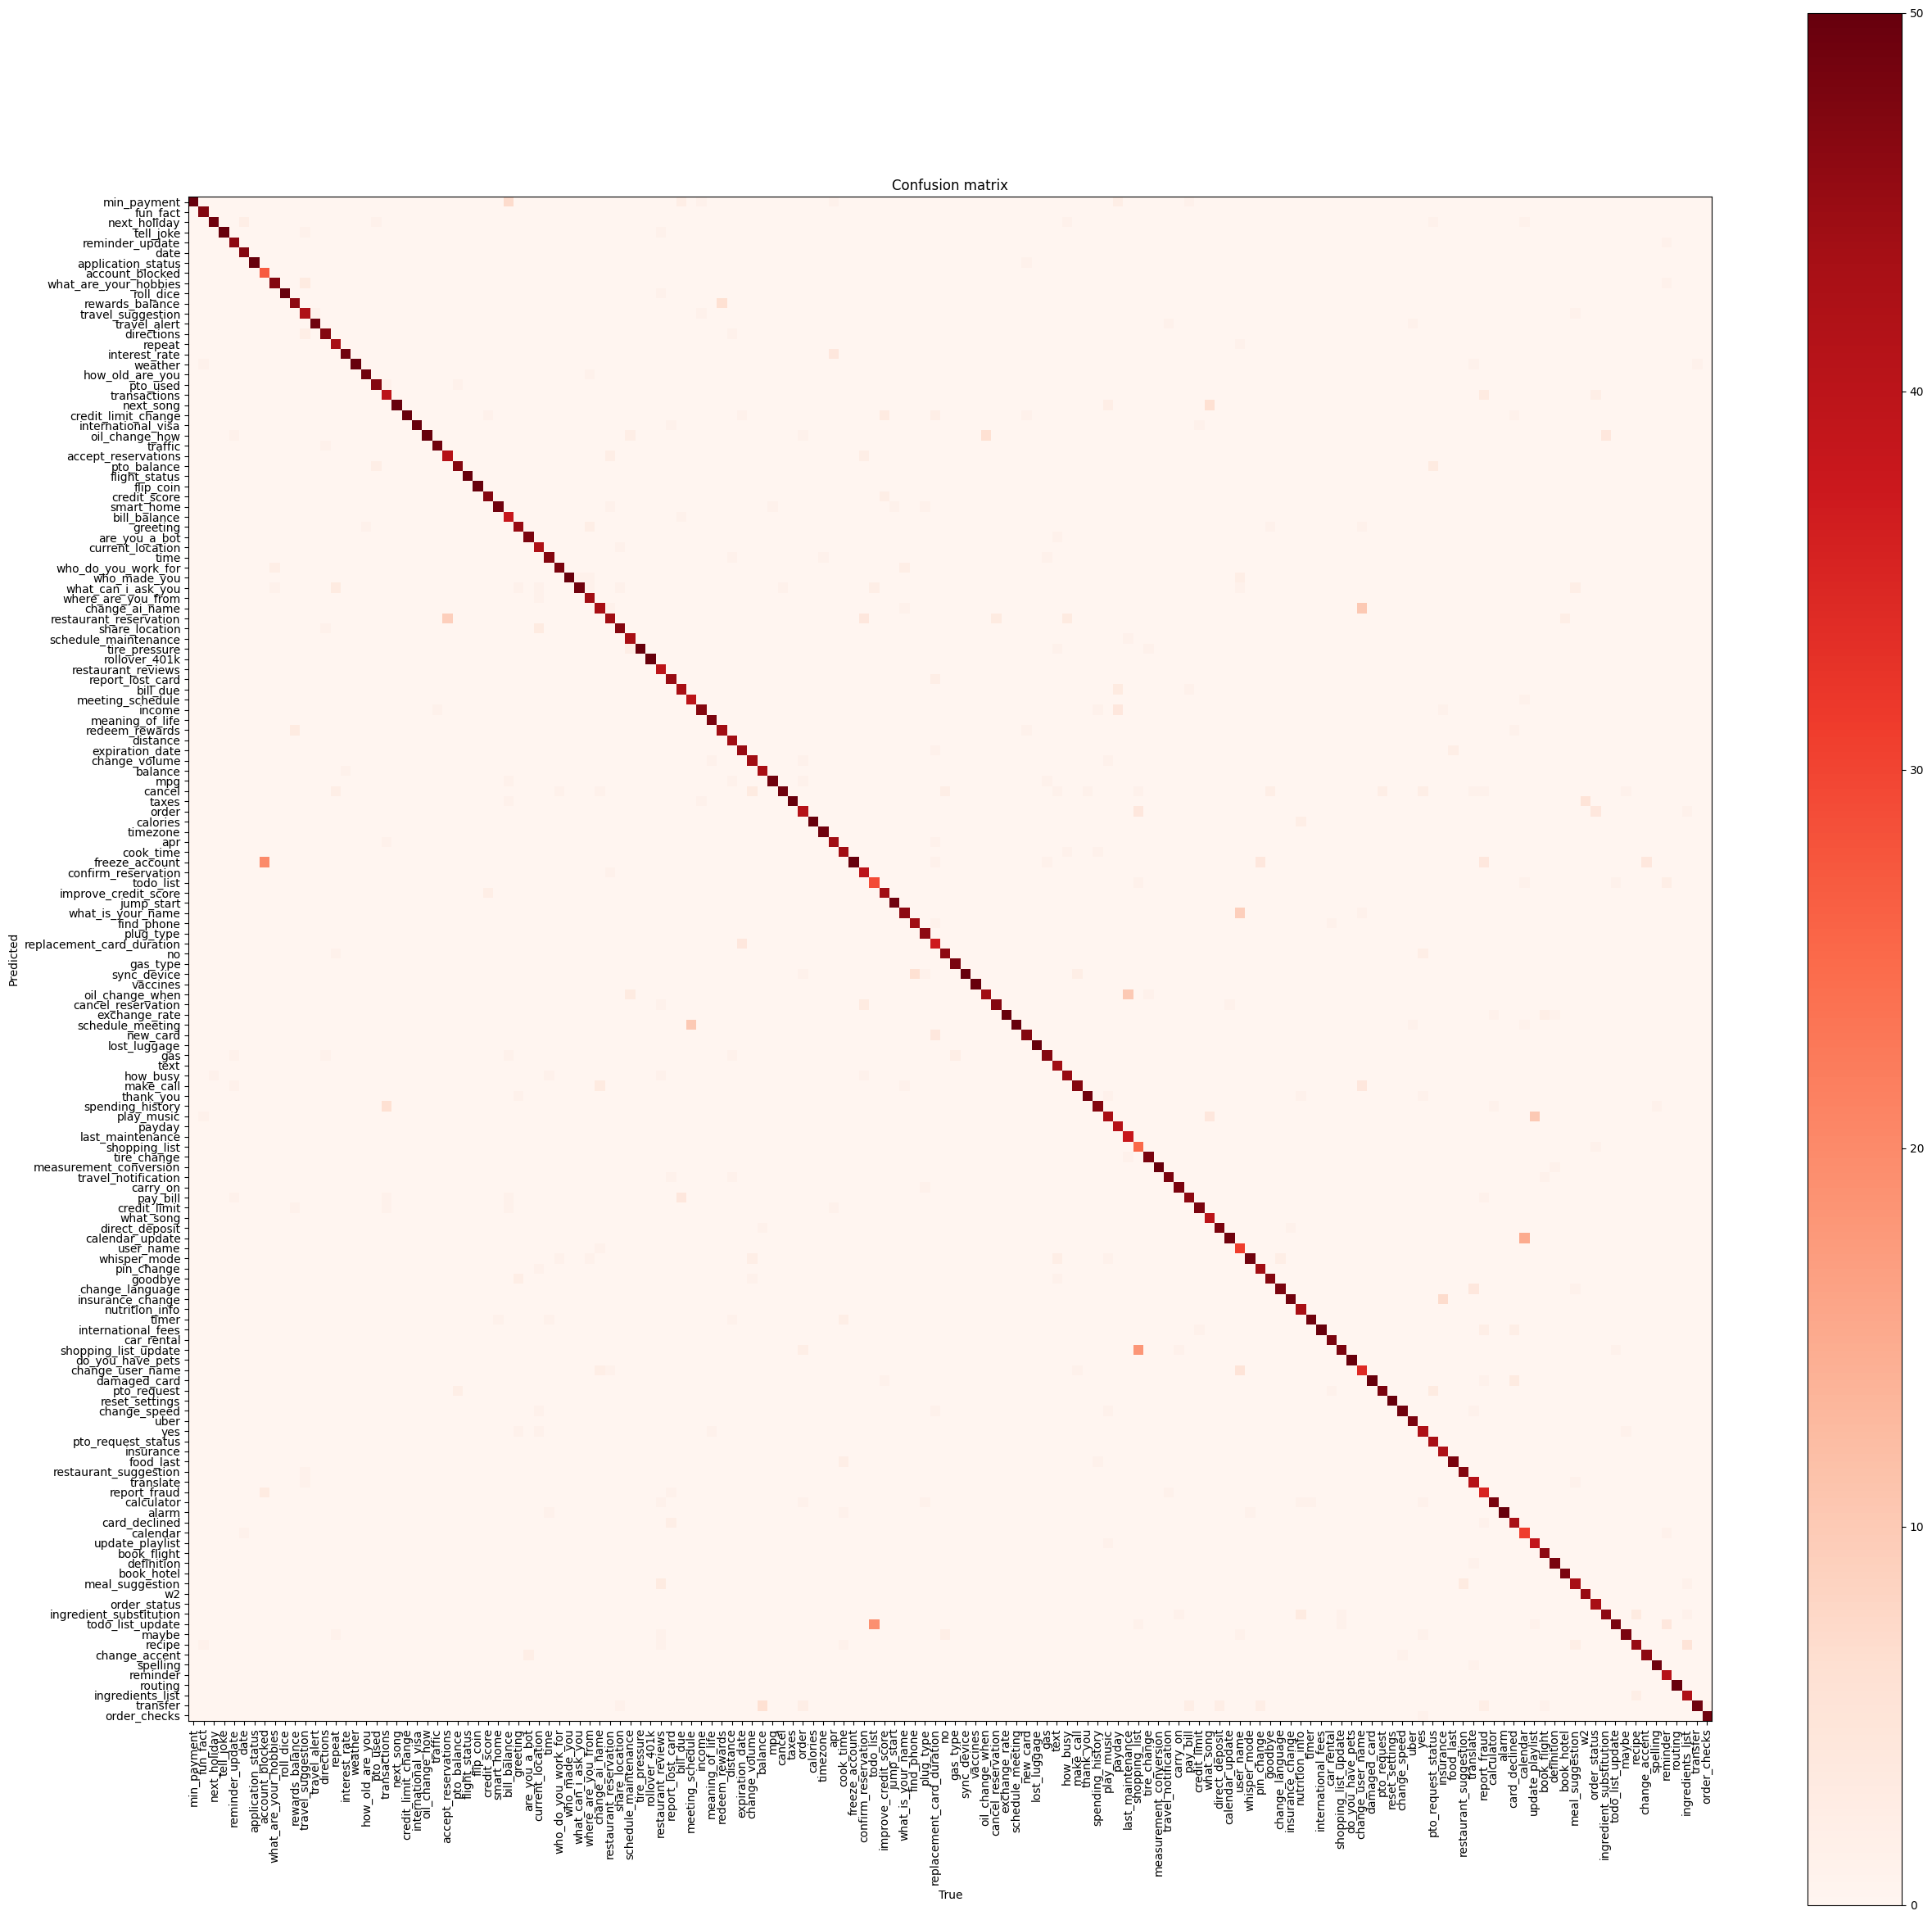

##################################################


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Optimizer: Adam Learning rate: 5e-05 Weight decay: 0.01 Num epochs: 10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch:   0%|          | 0/118 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:   0%|          | 0/118 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:   0%|          | 0/118 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:   0%|          | 0/118 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:   0%|          | 0/118 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:   0%|          | 0/118 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:   0%|          | 0/118 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:   0%|          | 0/118 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:   0%|          | 0/118 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:   0%|          | 0/118 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/59 [00:00<?, ?it/s]

Validation accuracy: 0.9305333333333333
Validation loss: 0.36349588102203306


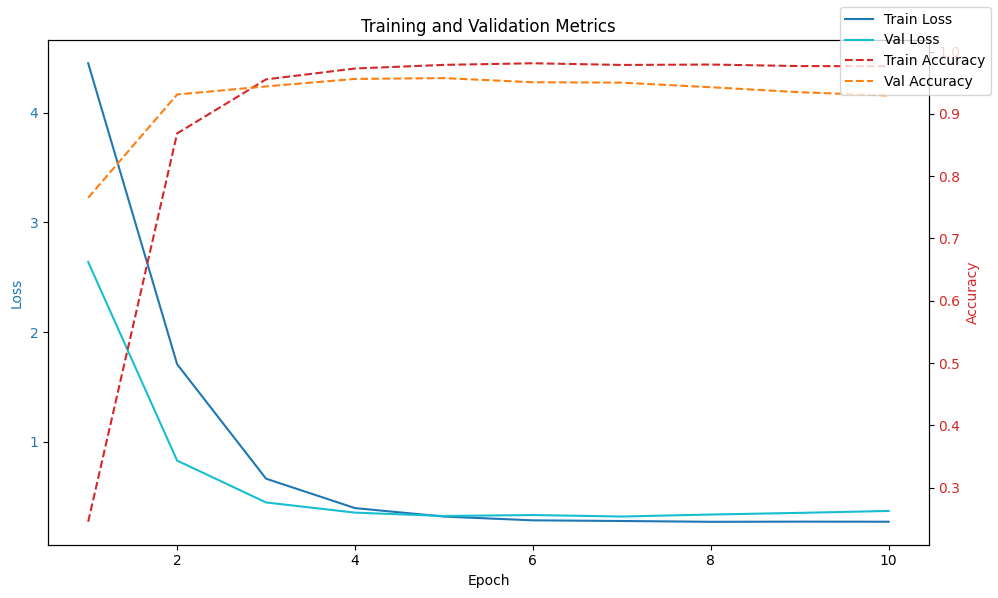

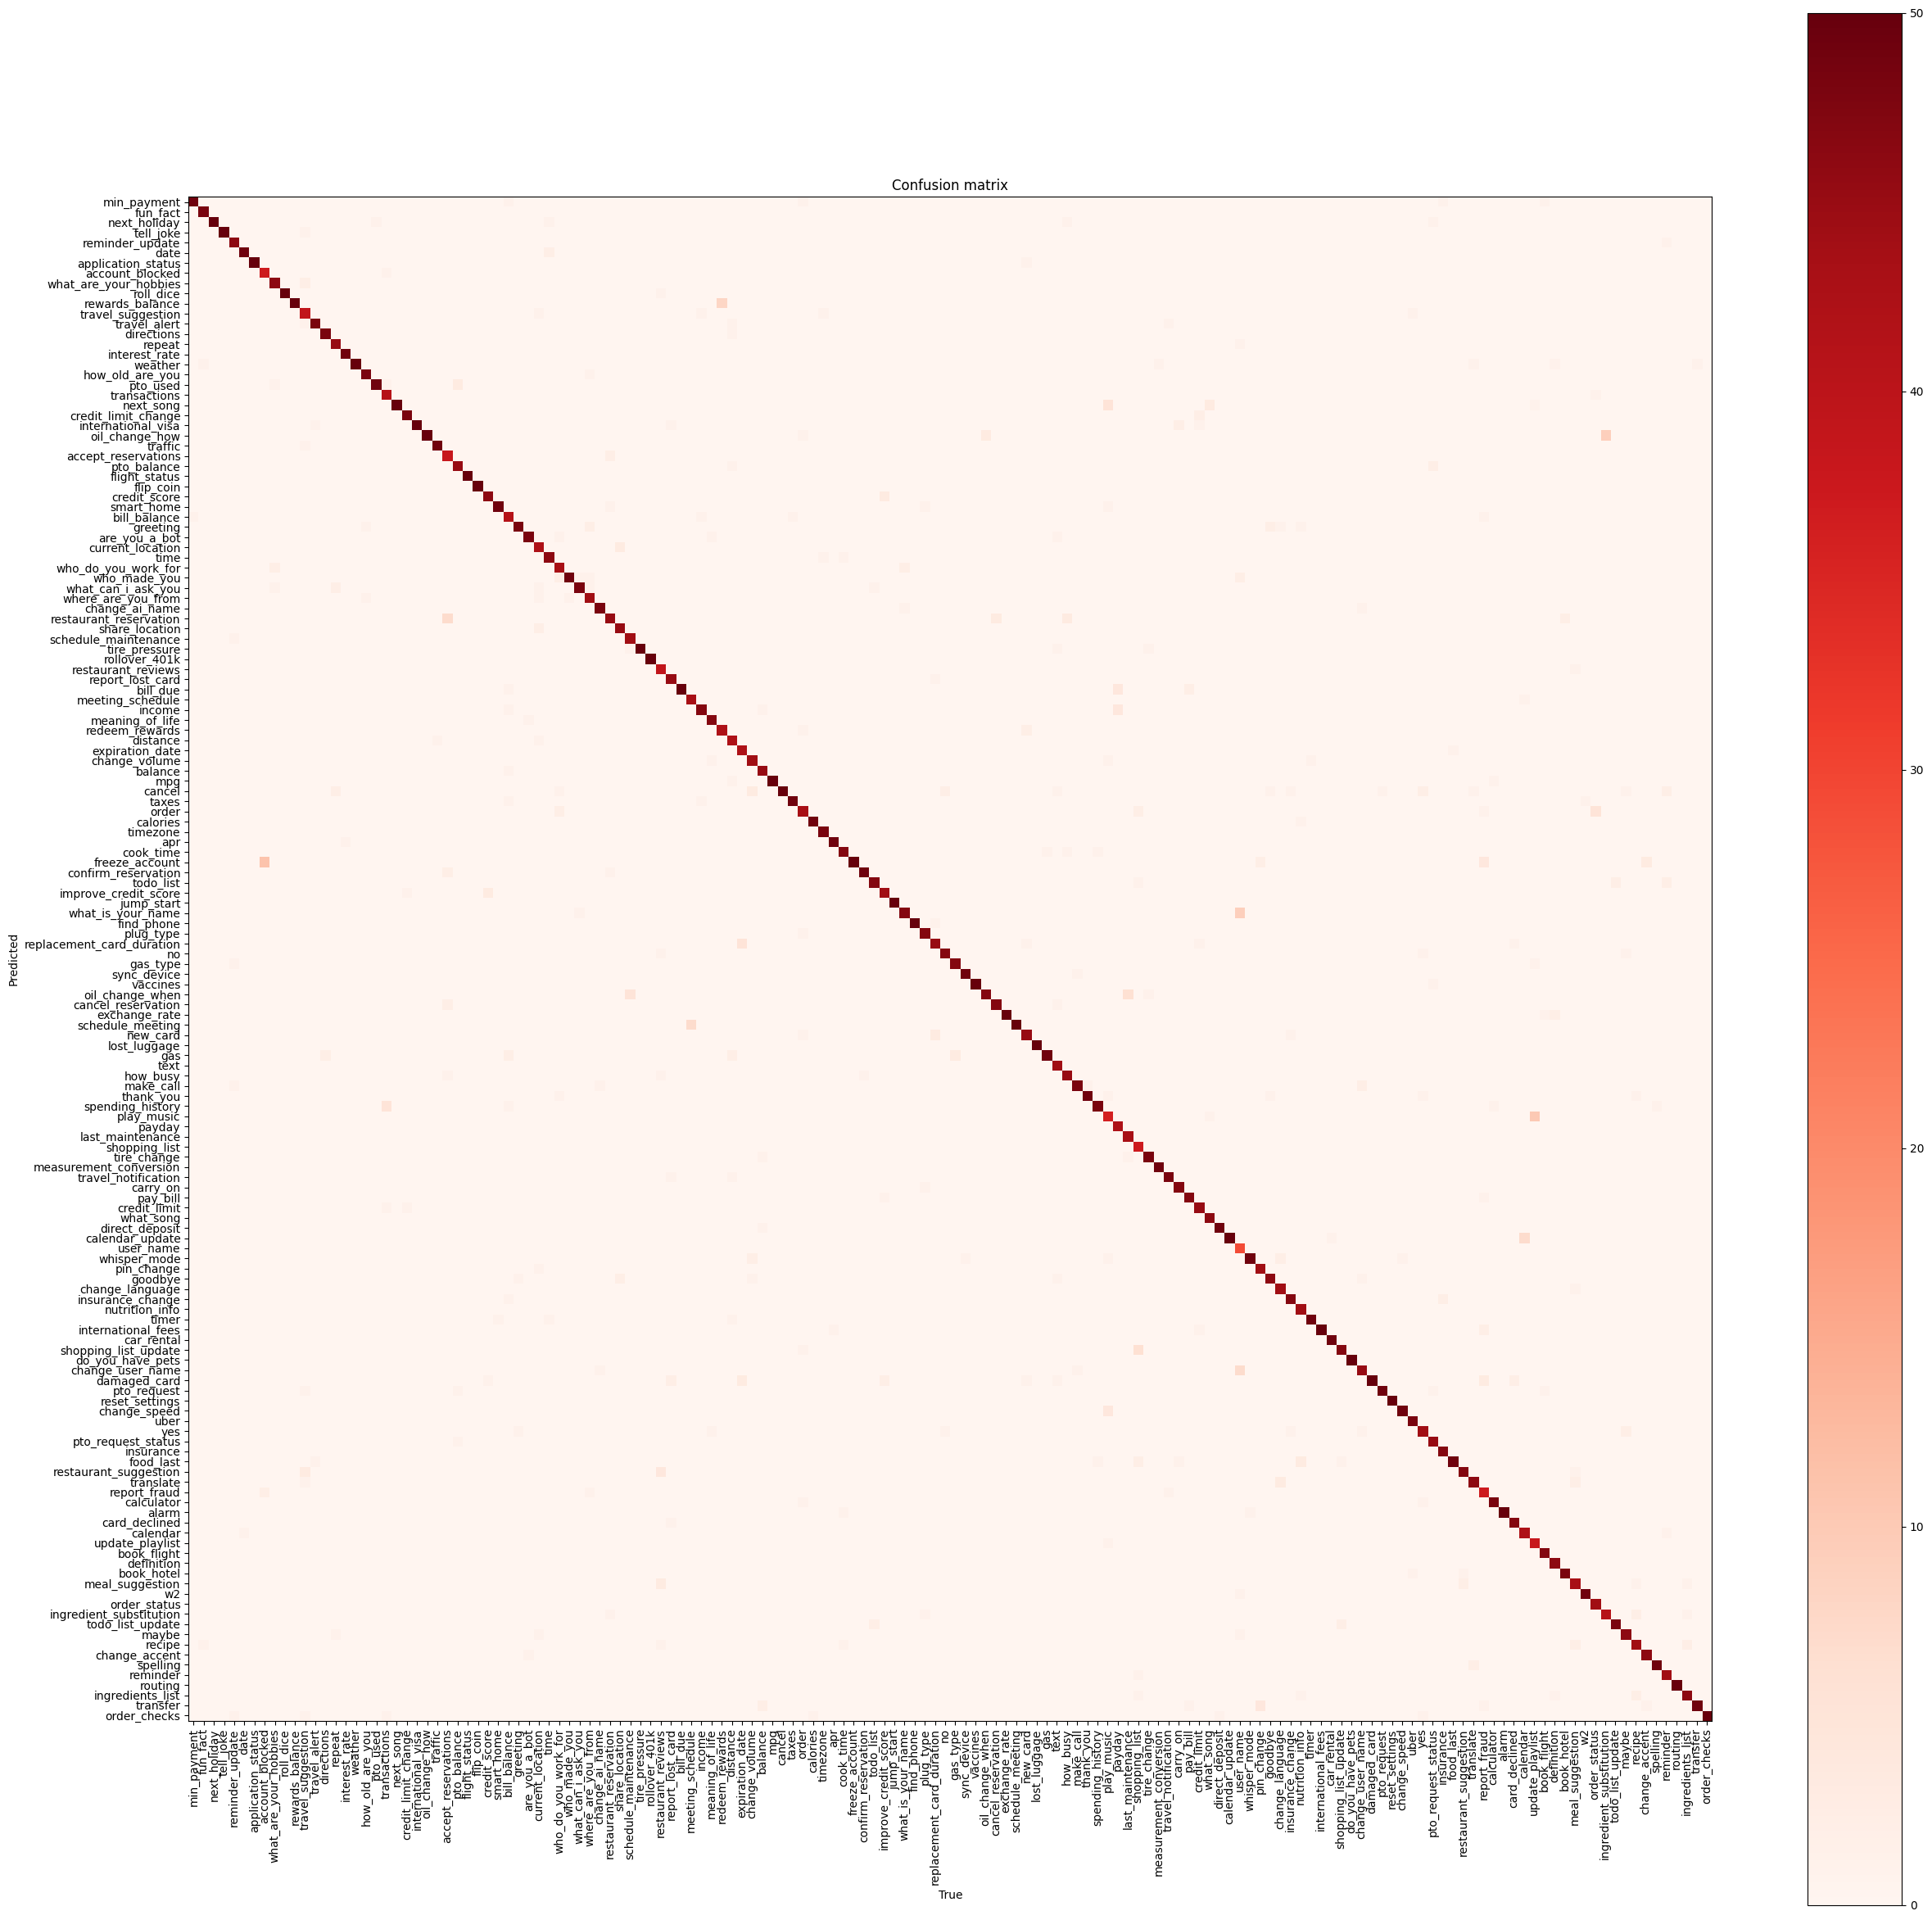

##################################################


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Optimizer: AdamW Learning rate: 5e-05 Weight decay: 0.01 Num epochs: 10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch:   0%|          | 0/118 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:   0%|          | 0/118 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:   0%|          | 0/118 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:   0%|          | 0/118 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:   0%|          | 0/118 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:   0%|          | 0/118 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:   0%|          | 0/118 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:   0%|          | 0/118 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:   0%|          | 0/118 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:   0%|          | 0/118 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/59 [00:00<?, ?it/s]

Validation accuracy: 0.9665333333333334
Validation loss: 0.17072762918295498


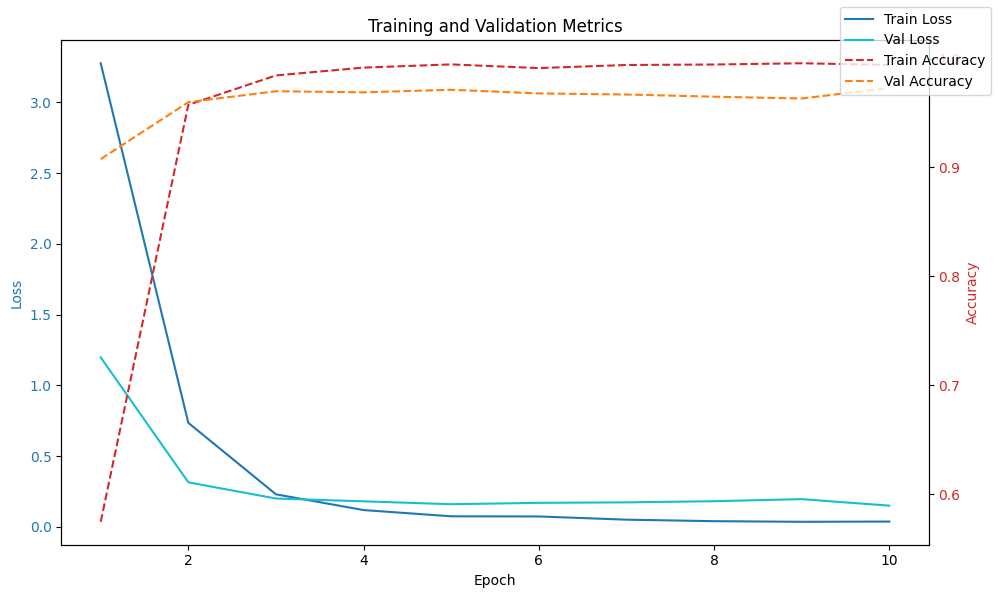

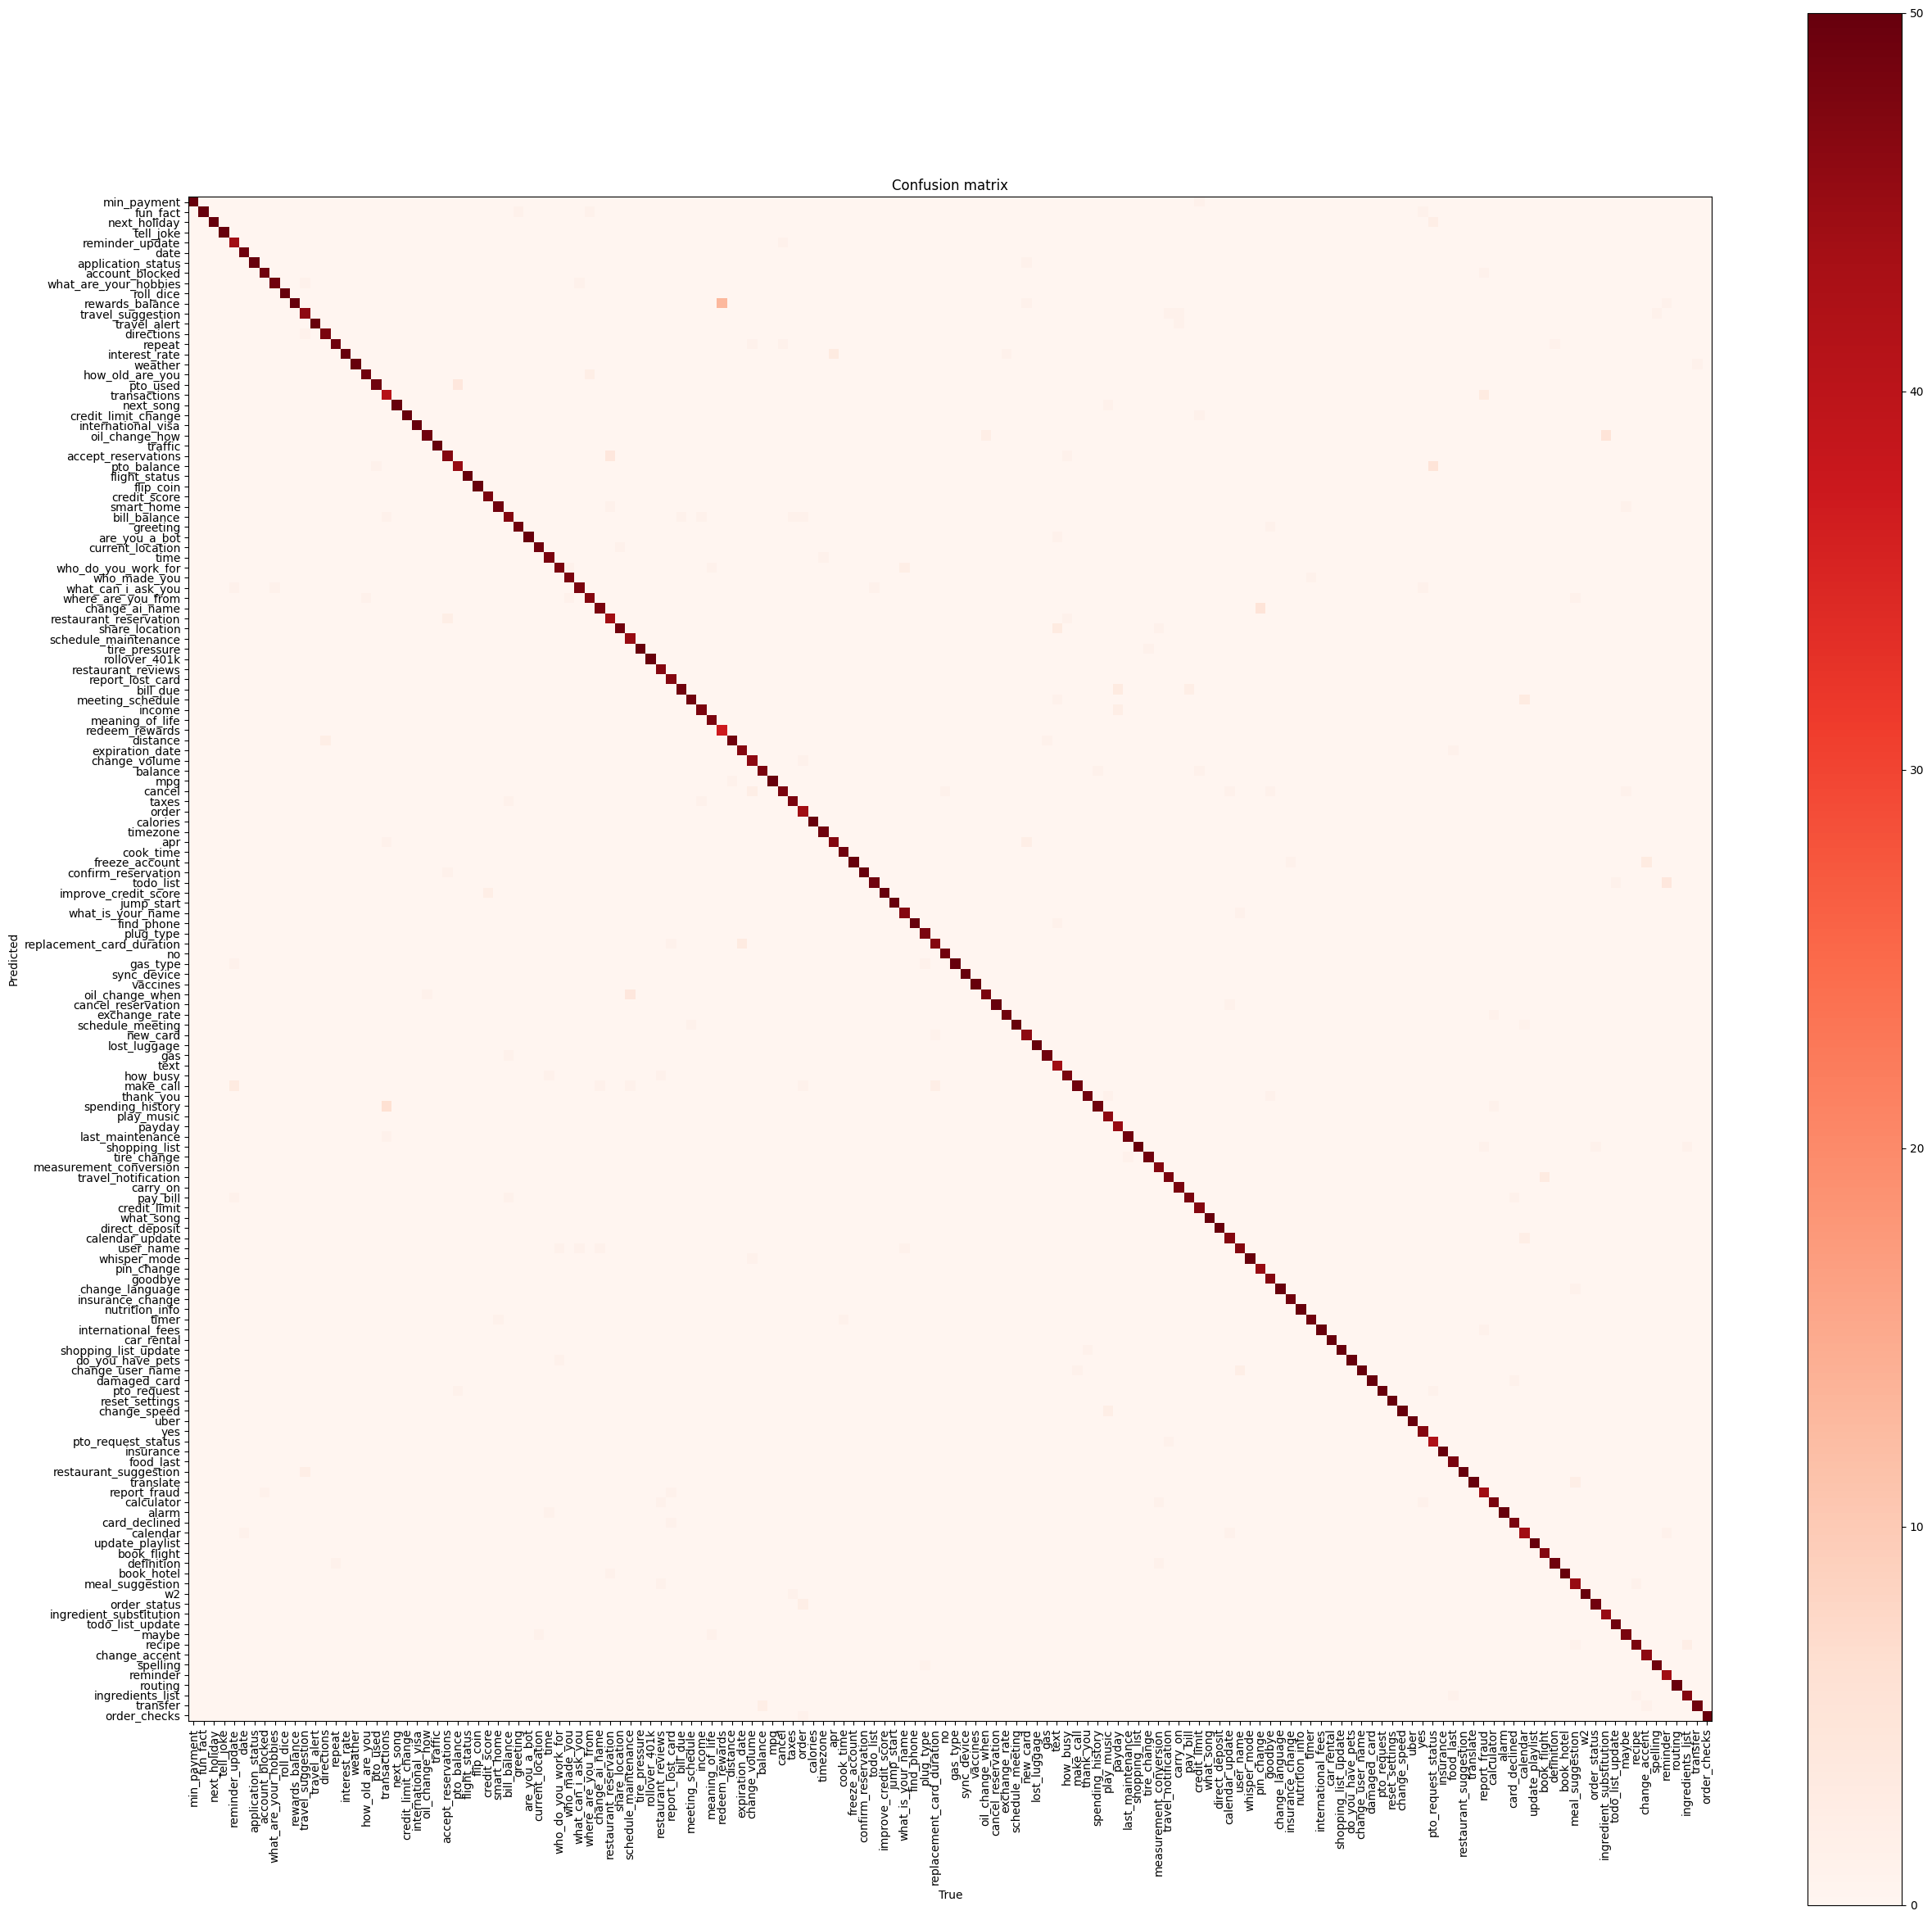

##################################################


In [22]:
for opt_name, config in configs.items():
    # set seed for reproducibility
    seed_everything(seed)

    # reload the original model
    model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=num_labels).to(device)

    optimizer = config.optimizer(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)

    print(f'Optimizer: {opt_name}', 'Learning rate:', config.learning_rate, 'Weight decay:', config.weight_decay, 'Num epochs:', config.num_epochs)

    training = train(model=model,
                     train_dataloader=train_dataloader,
                     val_dataloader=val_dataloader,
                     optimizer=optimizer,
                     scheduler=None,
                     num_epochs=config.num_epochs)

    evaluation = evaluate(model, test_dataloader)

    print(f'Validation accuracy: {evaluation.accuracy}')
    print(f'Validation loss: {evaluation.loss}')

    plot_training(training)
    plot_confusion_matrix(evaluation.confusion_matrix)

    # save the model
    torch.save(model.state_dict(), f'roberta_{opt_name}.pt')

    # release the memory
    del model
    del optimizer
    del training
    del evaluation
    gc.collect()
    torch.cuda.empty_cache()

    print('#' * 50)    